In [263]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [1174]:
def generate_data(xmin, xmax, num_points):
    rng = np.linspace(xmin, xmax, num_points)
    
    # Sin data
    ts = pd.Series(np.sin(rng), rng)
#     ts = ts + pd.Series(np.random.normal(-0.2, 0.2, size=len(rng)), rng)
    TS = np.array(ts)
    return TS

100


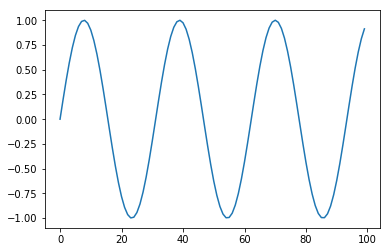

In [1175]:
TS = generate_data(0, 20, 100)
plt.plot(TS)
print(len(TS))

In [629]:
def next_batch(series, batch_sz, forecast):
    start_point = int(np.random.uniform(0, len(series)-batch_sz-forecast))
    x_batch = series[start_point:start_point+batch_sz].reshape(-1, batch_sz, 1)
    y_batch = series[start_point+forecast:start_point+batch_sz+forecast].reshape(-1, batch_sz, 1)
    ts = series[start_point:start_point+batch_sz+forecast]
    return x_batch, y_batch, ts

In [476]:
def next_batch(series, lookback, overlap, forecast):
    batch_sz = lookback + forecast
    start_point = int(np.random.uniform(0, len(series)-lookback-forecast))
    
    x_batch = series[start_point:start_point+lookback+overlap].reshape(-1, lookback+overlap, 1)
    y_batch = series[start_point+lookback-overlap:start_point+batch_sz].reshape(-1, forecast+overlap, 1)
    ts = series[start_point:start_point+batch_sz]
    return x_batch, y_batch, ts

250


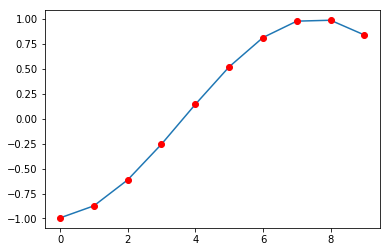

1 1


In [502]:
# Batch generation demo
print(len(TS))
x_batch, y_batch, ts = next_batch(TS, 10, 5)
plt.plot(ts.flatten()[5:])
plt.plot(y_batch.flatten(), "ro")
plt.show()
print(len(y_batch), len(x_batch))

In [175]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, batch_sz, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX, testY

x_test, y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)

(1, 20, 1)


In [834]:
def TestRNN(train_data_series, test_data, batch_sz=50, f_horizon=1, hidden_layers=100, learning_rate=0.001, init_cell=tf.contrib.rnn.BasicRNNCell, activation=tf.nn.relu, epochs=1000, print_epochs=False):
    tf.reset_default_graph()

    input_sz = 1
    output_sz = 1

    X = tf.placeholder(tf.float32, [None, batch_sz, input_sz])
    y = tf.placeholder(tf.float32, [None, batch_sz, output_sz])

    cell = init_cell(num_units=hidden_layers, activation=activation)
    rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden_layers])
    stacked_outputs = tf.layers.dense(stacked_rnn_output, output_sz)
    outputs = tf.reshape(stacked_outputs, [-1, batch_sz, output_sz])

    loss = tf.reduce_sum(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    
    # TRAIN
    mse_vals = []
    with tf.Session() as sess:
        init.run()
        for ep in range(epochs):
            x_batch, y_batch, ts = next_batch(train_data_series, batch_sz, f_horizon)
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
            if ep % 10 == 0:
                mse = loss.eval(feed_dict={X: x_batch, y: y_batch})
                mse_vals.append(mse)
                if ep % 500 == 0 and print_epochs:
                    print("Epoch:", ep, "MSE:", mse)

        mse = loss.eval(feed_dict={X: x_batch, y: y_batch})
        mse_vals.append(mse)

        y_preds = []
        for tests in range(10):
            x_test = test_data[0]
            y_test = test_data[1]
            y_pred = sess.run(outputs, feed_dict={X: x_test})
            y_preds.append(y_pred)    
    return np.mean(mse_vals[:10])

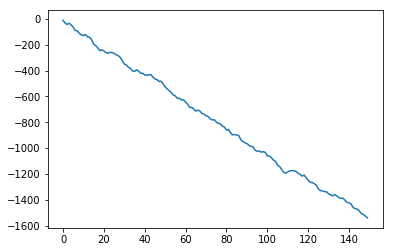

In [779]:
TS = generate_data(0, 100, 150)
plt.plot(TS)
batch_sz = 20
f_horizon = 10

In [716]:
# Optimization

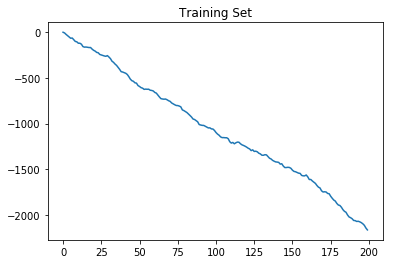

----------------------
--- CELL: <class 'tensorflow.python.ops.rnn_cell_impl.BasicRNNCell'>
----------------------
----------------------
--- CELL: <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>
----------------------
----------------------
--- CELL: <class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>
----------------------


In [876]:
hidden_layer_values = [10, 50, 100, 200]
batch_sizes = [10, 15, 20]
f_horizons = [5, 10, 20, 30]
epochs = [3000]
cell_types = [tf.contrib.rnn.BasicRNNCell, tf.contrib.rnn.GRUCell, tf.contrib.rnn.LSTMCell]
n_trials_per_test = 3

total_tests = len(hidden_layer_values)*len(batch_sizes)*len(f_horizons)*len(epochs)*len(cell_types)*n_trials_per_test

param_outputs = {
#     (hl, bz, f, epochs, cell): avg_mse
}

training_set = generate_data(0, 500, 200)
plt.plot(training_set)
plt.title('Training Set')
plt.show()

trial_count = 0
for cell in cell_types:
    print('----------------------')
    print("--- CELL:", cell)
    print('----------------------')
    for n_hidden in hidden_layer_values:
        for n_epochs in epochs:
            for batch_sz in batch_sizes:
                for f in f_horizons:
                    
                    mse_vals = []
                    for i in range(n_trials_per_test):
                        # Test this architecture 3 times
                        training_set = generate_data(0, 500, 200)
                        x_test, y_test, _ = next_batch(training_set, batch_sz, f)
                        mse_for_test = TestRNN(training_set, [x_test, y_test], hidden_layers=n_hidden, 
                                                batch_sz=batch_sz, f_horizon=f, epochs=n_epochs, print_epochs=False)
                        mse_vals.append(mse_for_test)
                        
                        # Calculate percentage complete
                        trial_count += 1
                        percent_complete = trial_count / total_tests // .001 / 1000 * 100
                        print("%s%%" % percent_complete, end="\r", flush=False)
                    
                    param_outputs[(n_hidden, batch_sz, f, n_epochs, cell)] = np.mean(mse_vals) # mean of 10 trials
#                     print('MSE:', np.mean(mse_vals))
#                     print('------')

Epoch: 0 MSE: 3057254.0
Epoch: 500 MSE: 414836.3
MSE: 224736.81


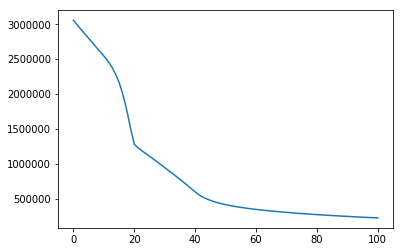

879573.44

In [801]:
TestRNN(training_set, [x_test, y_test], hidden_layers=10, batch_sz=10, f_horizon=40)

In [877]:
min(param_outputs.values())

1003932.5

In [879]:
results = [(x, param_outputs[x]) for x in param_outputs]
results_sorted = sorted(results, key=lambda x: x[1])
results_sorted

[((200, 10, 5, 3000, tensorflow.python.ops.rnn_cell_impl.BasicRNNCell),
  1003932.5),
 ((200, 10, 20, 3000, tensorflow.python.ops.rnn_cell_impl.GRUCell), 1508431.6),
 ((100, 10, 10, 3000, tensorflow.python.ops.rnn_cell_impl.GRUCell), 1551650.0),
 ((200, 10, 20, 3000, tensorflow.python.ops.rnn_cell_impl.BasicRNNCell),
  1598410.4),
 ((200, 10, 10, 3000, tensorflow.python.ops.rnn_cell_impl.LSTMCell),
  1629005.5),
 ((200, 15, 10, 3000, tensorflow.python.ops.rnn_cell_impl.GRUCell), 1662158.0),
 ((200, 20, 10, 3000, tensorflow.python.ops.rnn_cell_impl.BasicRNNCell),
  1666687.4),
 ((200, 10, 10, 3000, tensorflow.python.ops.rnn_cell_impl.BasicRNNCell),
  1743620.0),
 ((200, 15, 10, 3000, tensorflow.python.ops.rnn_cell_impl.BasicRNNCell),
  1743861.5),
 ((100, 10, 20, 3000, tensorflow.python.ops.rnn_cell_impl.BasicRNNCell),
  1842319.0),
 ((200, 10, 5, 3000, tensorflow.python.ops.rnn_cell_impl.GRUCell), 1980721.6),
 ((50, 10, 30, 3000, tensorflow.python.ops.rnn_cell_impl.GRUCell), 1997360.1)

[10.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 17.0, 17.0, 18.0, 19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23.0, 23.0, 25.0, 26.0, 27.0, 27.0, 28.0, 29.0, 29.0, 29.0, 29.0, 29.0, 30.0, 30.0, 31.0, 31.0, 32.0, 32.0, 33.0, 34.0, 34.0, 34.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 38.0, 38.0, 39.0, 39.0, 39.0, 41.0, 41.0, 41.0, 42.0, 42.0, 43.0, 44.0, 45.0, 45.0, 46.0, 47.0, 47.0, 47.0, 47.0, 49.0, 50.0, 50.0, 50.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 55.0, 55.0, 56.0, 56.0, 56.0, 56.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 62.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 67.0, 70.0, 73.0, 73.0, 74.0, 75.0, 75.0, 77.0, 78.0, 80.0, 81.0, 82.0, 83.0, 85.0, 91.0, 95.0, 101.0, 105.0, 113.0, 127.0, 129.0, 130.0, 132.0, 141.0, 143.0, 145.0, 145.0, 147.0, 152.0, 153.0, 157.0, 158.0, 161.0, 167.0, 172.0, 185.0, 189.0, 196.0, 228.0, 230.0, 231.0, 236.0, 261.0]


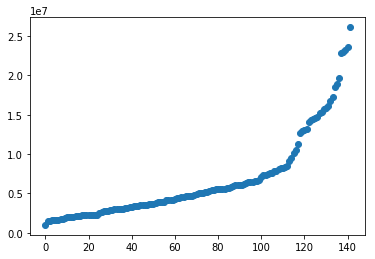

In [882]:
print([x[1]/1e7 // 0.01 for x in results_sorted[:-2]])
plt.plot([x[1] for x in results_sorted[:-2]], 'o')
plt.show()

In [866]:
6 / 893 // .0001 / 10000

0.0067

In [867]:
6 / 893

0.006718924972004479

# Keras

In [1128]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from IPython.display import clear_output

In [1129]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

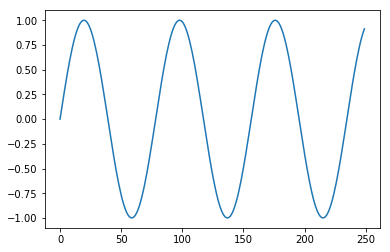

In [1176]:
data = generate_data(0, 20, 250)
plt.plot(data)

In [1177]:
seq_len = 30

someX = np.array([])
someY = np.array([])
for x in range(599):
    xBatch, yBatch, tsBatch = next_batch(data, seq_len, 15)
    someX = np.append(someX, xBatch)
    someY = np.append(someY, yBatch)
    
someX = someX.reshape(-1, seq_len, 1) # 1000 samples, 30 time steps, 1 feature
someY = someY.reshape(-1, seq_len, 1)

In [1132]:
model = Sequential()
model.add(LSTM(units=seq_len, input_shape=(seq_len, 1), return_sequences=True))
# model.add(LSTM(units=seq_len, activation='relu', input_shape=(seq_len, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1))) # Output 1 value per time step

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 30, 30)            3840      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 1)             31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


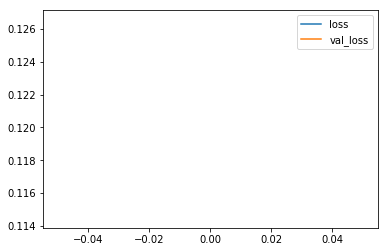

Epoch 2/100
182/599 [========>.....................] - ETA: 7s - loss: 0.1215

KeyboardInterrupt: 

In [1142]:
model.fit(someX, someY, batch_size=2, epochs=100, callbacks=[plot_losses], verbose=1, shuffle=True)

[ 0.23363082  0.20023836  0.05909295  0.08760169  0.03242164  0.17047949
  0.10574441 -0.00180586 -0.18290636 -0.36072144 -0.29880455 -0.29605395
 -0.4196572  -0.52626276 -0.61335456 -0.720274   -0.8561095  -0.9178945
 -1.0166312  -1.0362005  -1.0020686  -1.0197228  -1.0965745  -1.198949
 -1.2489675  -1.2305546  -1.2128942  -1.1957545  -1.190295   -1.170181  ]


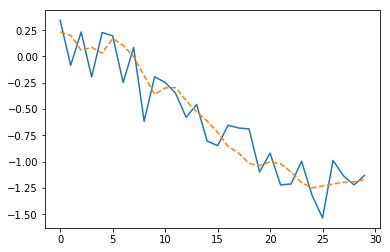

In [1173]:
xTest, yTest, tsTest = next_batch(data, seq_len, 15)
result = model.predict(xTest, batch_size=seq_len)

plt.plot(yTest.flatten())
plt.plot(result.flatten(), '--')
print(result.flatten())

In [1206]:
autoencoder = Sequential()
autoencoder.add(LSTM(units=30, input_shape=(30, 1), return_sequences=True, name="layer1", activation='relu'))
autoencoder.add(LSTM(units=30, return_sequences=True, name='layer2', activation='relu'))
autoencoder.add(TimeDistributed(Dense(1)))

autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
layer2 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 1)             31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


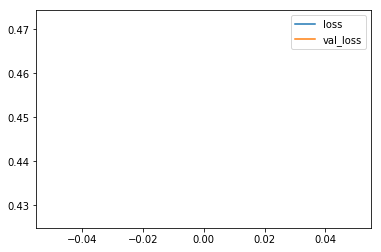

In [1215]:
autoencoder.fit(someX, someX, batch_size=200, epochs=1, callbacks=[plot_losses], verbose=1, shuffle=True)

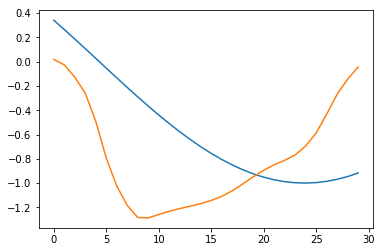

In [1218]:
xTest, yTest, tsTest = next_batch(data, seq_len, 0)
result = model.predict(xTest, batch_size=seq_len)
plt.plot(xTest.flatten())
plt.plot(result.flatten())
plt.show()

In [1196]:
xTest.flatten()

array([ 0.74948512,  0.800186  ,  0.84572725,  0.88581521,  0.9201914 ,
        0.94863416,  0.97096009,  0.98702522,  0.99672598,  0.99999981,
        0.99682559,  0.98722381,  0.97125636,  0.94902622,  0.92067671,
        0.88639064,  0.84638909,  0.80092999,  0.75030645,  0.69484492,
        0.63490299,  0.57086718,  0.5031504 ,  0.43218928,  0.35844139,
        0.28238225,  0.2045023 ,  0.12530371,  0.04529716, -0.03500147])

In [1198]:
result.flatten()

array([ 0.16208906,  0.19189297,  0.19673592,  0.20973726,  0.1978685 ,
        0.17901735,  0.1584015 ,  0.13168882,  0.09766781,  0.0594822 ,
        0.02214081, -0.00966554, -0.03504591, -0.05659576, -0.07929222,
       -0.10983369, -0.15523285, -0.21990512, -0.30124056, -0.38644868,
       -0.4586781 , -0.5099569 , -0.54471827, -0.574435  , -0.61236787,
       -0.66953033, -0.7719497 , -0.8800379 , -0.970629  , -1.0486408 ],
      dtype=float32)